In [1]:
from spacerocks import SpaceRock
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time
from spacerocks.nbody import Simulation, Integrator

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

In [2]:
epoch = Time.now()

planets_names = ["sun", 
                 "jupiter barycenter", 
                 "saturn barycenter", 
                 "uranus barycenter", 
                 "neptune barycenter"]
rocks = [SpaceRock.from_horizons("Arrokoth", epoch=Time.now(), origin="ssb", reference_plane="ECLIPJ2000")]
planets = [SpaceRock.from_spice(name, epoch, reference_plane="ECLIPJ2000", origin='ssb') for name in planets_names]

In [3]:
sim = Simulation()

sim.set_epoch(epoch)
sim.set_reference_plane("ECLIPJ2000")
sim.set_origin('ssb')
sim.set_integrator(Integrator.ias15(timestep=20.0))


for planet in planets:
    sim.add(planet)
    
for rock in rocks:
    sim.add(rock)

sim.move_to_center_of_mass()
E0 = sim.energy()


In [4]:
dts = np.linspace(0, 365.25 * 100_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [5]:
semimajors = []
for epoch in epochs:
    sim.integrate(epoch)
    semimajors.append(sim.get_particle("Arrokoth").a())

(2460686.1873842594, 38985686.18738426)

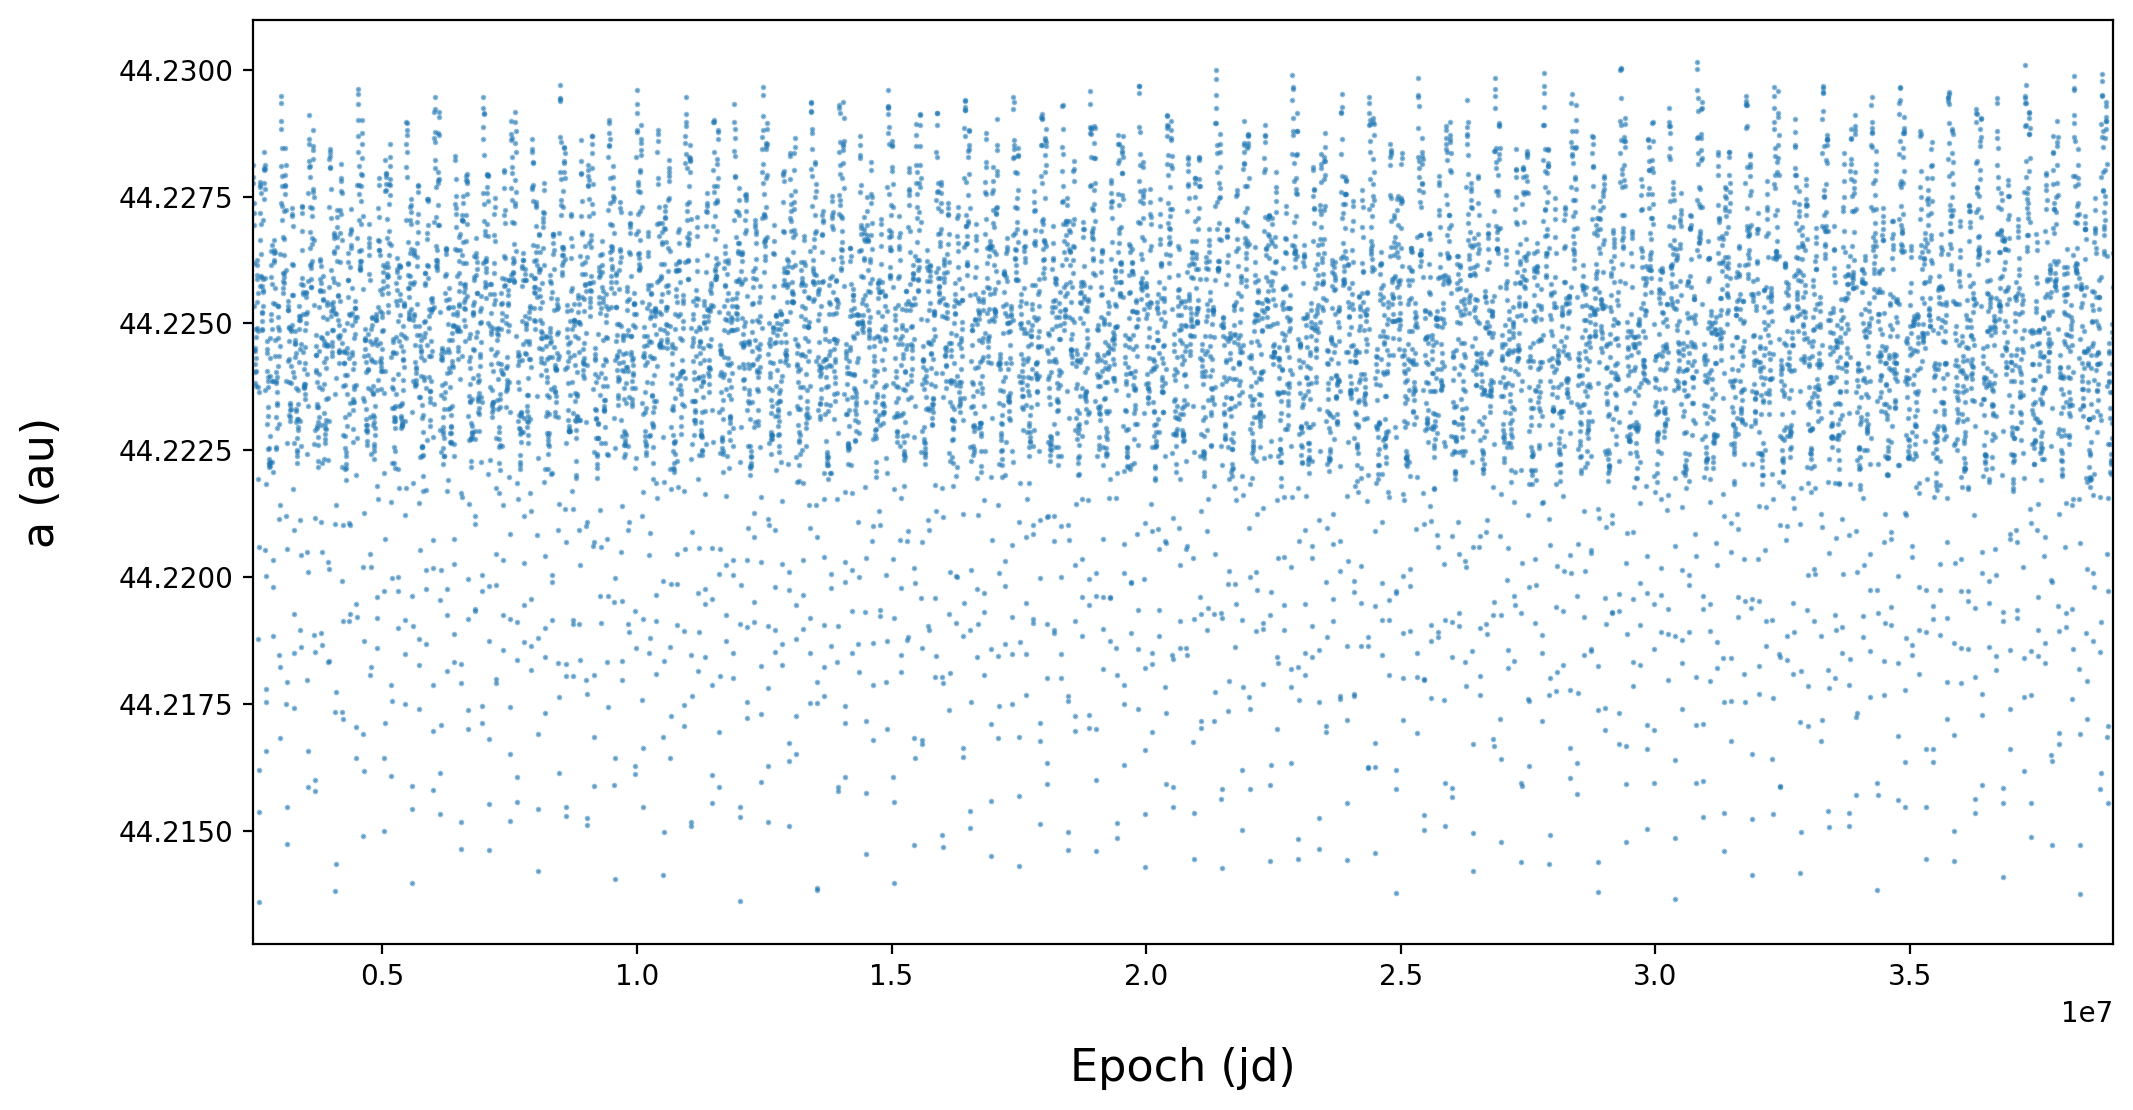

In [6]:
fig, ax = plt.subplots(figsize=(12, 6))

eps = [epoch.utc().jd() for epoch in epochs]
ax.scatter(eps, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('a (au)', fontsize=16, labelpad=20)
ax.set_xlim(eps[0], eps[-1])

In [7]:
import rebound

In [8]:
rsim = rebound.Simulation()
rsim.units = ('au', 'day', 'Msun')

epoch = Time.now()

planets_names = ["sun", 
                 "jupiter barycenter", 
                 "saturn barycenter", 
                 "uranus barycenter", 
                 "neptune barycenter"]
rocks = [SpaceRock.from_horizons("Arrokoth", epoch=Time.now(), origin="ssb", reference_plane="ECLIPJ2000")]
planets = [SpaceRock.from_spice(name, epoch, reference_plane="ECLIPJ2000", origin='ssb') for name in planets_names]

rsim.t = epoch.utc().jd()
rsim.integrator = "ias15"
rsim.dt = 20.0


for planet in planets:
    rsim.add(x=planet.x, y=planet.y, z=planet.z, vx=planet.vx, vy=planet.vy, vz=planet.vz, m=planet.mass)
    
for rock in rocks:
    rsim.add(x=rock.x, y=rock.y, z=rock.z, vx=rock.vx, vy=rock.vy, vz=rock.vz, m=rock.mass)
    
rsim.move_to_com()

dts = np.linspace(0, 365.25 * 100_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [9]:
semimajors = []
for epoch in epochs:
    rsim.integrate(epoch.utc().jd())
    semimajors.append(rsim.particles[-1].a)

(2460686.1875462965, 38985686.1875463)

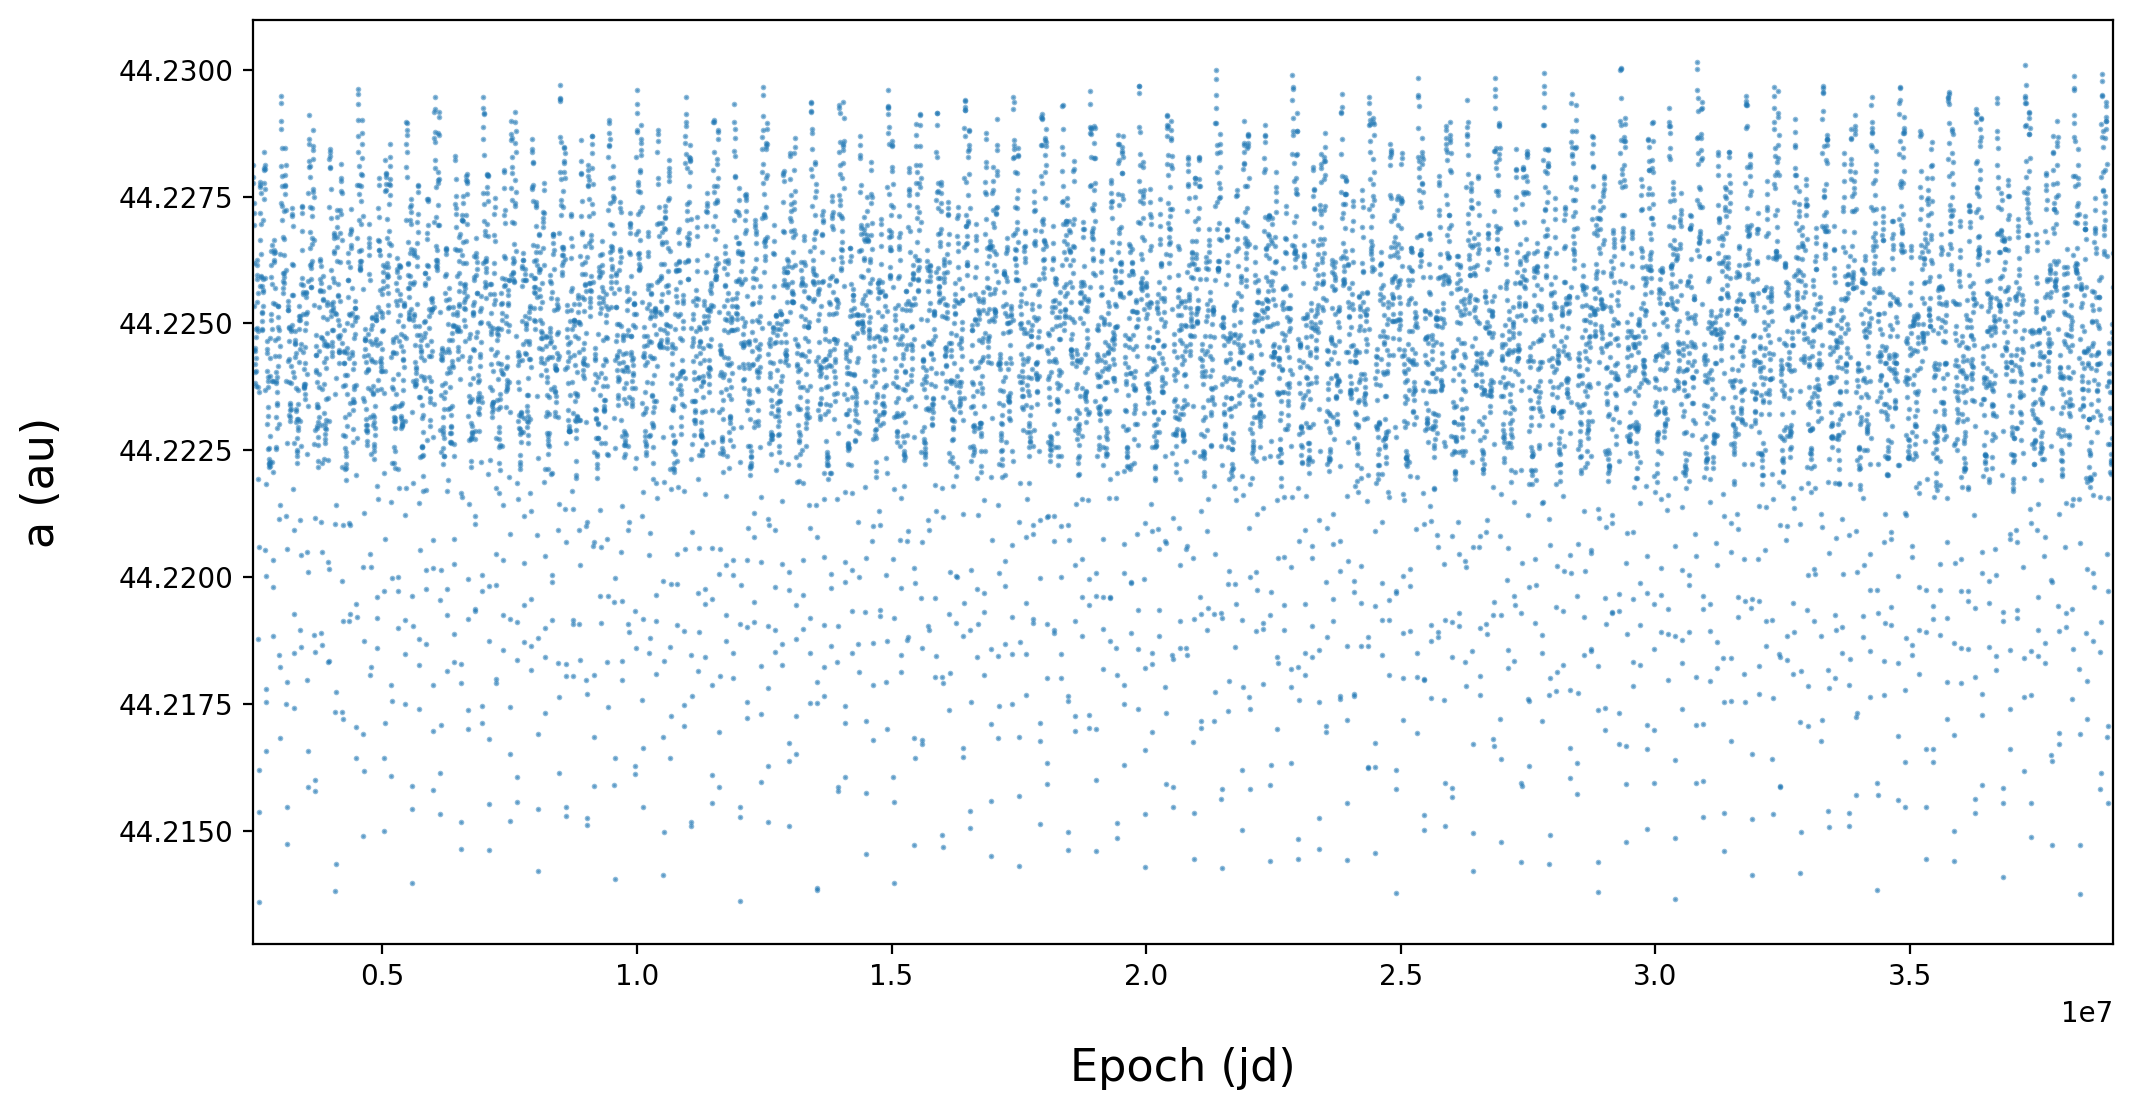

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))

eps = [epoch.utc().jd() for epoch in epochs]
ax.scatter(eps, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('a (au)', fontsize=16, labelpad=20)
ax.set_xlim(eps[0], eps[-1])